### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/rtide/

/content/drive/My Drive/rtide


In [3]:
!pip install utide

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.2/75.2 kB 5.5 MB/s eta 0:00:00


In [4]:
!pip install skyfield

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.2/336.2 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 17.5 MB/s eta 0:00:00


In [5]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 33.7 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
dates = [2014,2015,2016,2017,2018]
dir = "./examples/data/"

dfs = []
for i in dates:
  file_path = dir + f'moneypoint_{i}.csv'
  file_path_met = dir + f'moneypoint_{i}_met.csv'

  df = pd.read_csv(file_path)
  df_met = pd.read_csv(file_path_met)

  # Combine the 'Date' and 'Time (GMT)' columns into a single datetime column
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time (GMT)'], format='%Y/%m/%d %H:%M', utc = True)
  df_met['datetime'] = pd.to_datetime(df_met['Date'] + ' ' + df_met['Time (GMT)'], format='%Y/%m/%d %H:%M', utc = True)

  # Set the datetime column as the index
  df.set_index('datetime', inplace=True)
  df_met.set_index('datetime', inplace=True)

  # Drop the 'Date' and 'Time (GMT)' columns if needed
  if 'Forecast Guidance(m)' in df.columns:
    df.drop(columns=['Date', 'Time (GMT)', 'Preliminary (m)', 'Forecast Guidance(m)', 'Predicted (m)'], inplace=True)
  else:
    df.drop(columns=['Date', 'Time (GMT)', 'Preliminary (m)'], inplace=True)
  df_met.drop(columns=['Date', 'Time (GMT)', 'Humidity (%)'], inplace=True)

  merged_df = pd.merge(df, df_met, left_index=True, right_index=True, how='inner')
  dfs.append(merged_df)

final = pd.concat([dfs[i] for i in range(len(dfs))], join='outer', axis=0)

numeric_columns = final.columns
final[numeric_columns] = final[numeric_columns].apply(pd.to_numeric, errors='coerce')

final['Wind U'] = final['Wind Speed (m/s)'] * np.cos(final['Wind Dir (deg)'] * np.pi /180)
final['Wind V'] = final['Wind Speed (m/s)'] * np.sin(final['Wind Dir (deg)'] * np.pi /180)

final.drop(columns=['Wind Dir (deg)', 'Wind Speed (m/s)', 'Wind Gust (m/s)'], inplace=True)

final.rename(columns={'Verified (m)': 'observations'}, inplace=True)

new_index = pd.date_range(start=final.index[0], end=final.index[-1], freq='1H', tz='UTC')
df = final.reindex(new_index)

### Running RTide

In [7]:
import rtide
from rtide import RTide

/usr/local/lib/python3.10/dist-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/usr/local/lib/python3.10/dist-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


In [8]:
model = RTide(df[:8760], lat = 36.467, lon = 76.181)

In [9]:
inputs = {
    'symmetrical': True,
    'path': 'meteo',
    'sample_rate': 1,
    'radiational': True,
    'multivariate_lags': 'negative'
}

model.Prepare_Inputs(**inputs)

#### Model Overview ####
Learning Rate: 0.0001
Loss: MSE
Linear Epochs: 0
Standard Epochs: 500
Regularization: 0.001
Number of Layers: 3
Multi: True
Save Weights: True
Epoch 1/500
215/215 - 4s - loss: 1.7836 - val_loss: 1.5577 - lr: 1.0000e-04 - 4s/epoch - 17ms/step
Epoch 2/500
215/215 - 1s - loss: 1.6818 - val_loss: 1.5910 - lr: 1.0000e-04 - 897ms/epoch - 4ms/step
Epoch 3/500
215/215 - 1s - loss: 1.6753 - val_loss: 1.5170 - lr: 1.0000e-04 - 973ms/epoch - 5ms/step
Epoch 4/500
215/215 - 1s - loss: 1.6753 - val_loss: 1.6304 - lr: 1.0000e-04 - 771ms/epoch - 4ms/step
Epoch 5/500
215/215 - 1s - loss: 1.6281 - val_loss: 1.4969 - lr: 1.0000e-04 - 591ms/epoch - 3ms/step
Epoch 6/500
215/215 - 1s - loss: 1.6477 - val_loss: 1.5744 - lr: 1.0000e-04 - 610ms/epoch - 3ms/step
Epoch 7/500
215/215 - 1s - loss: 1.6029 - val_loss: 1.6442 - lr: 1.0000e-04 - 676ms/epoch - 3ms/step
Epoch 8/500
215/215 - 1s - loss: 1.6579 - val_loss: 1.5217 - lr: 1.0000e-04 - 582ms/epoch - 3ms/step
Epoch 9/500
215/215 - 1s -

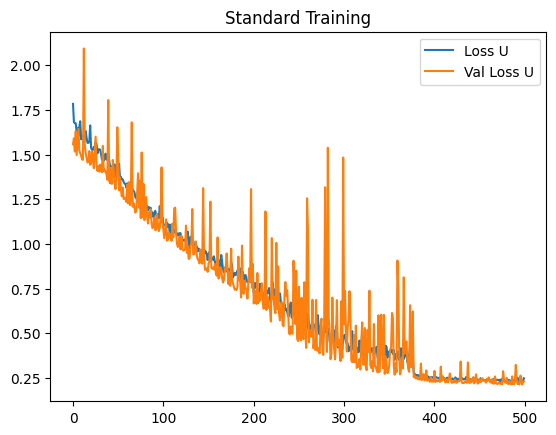

253/253 [==============================] - 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
train_inputs = {
    'loss': 'MSE',
    'lr': 1e-04,
    'early_stoppage': 30,
    'save_weights': True,
    'regularization_strength': 0.001,
    'standard_epochs': 500
}

model.Train(**train_inputs)

In [12]:
model.Predict(df[8760:10000])

Computing input functions for prediction
Input function path either has not specified, has not yet been computed, or different inputs were provided. Computing now...
Actual error was exceptions must derive from BaseException


100%|██████████| 1540/1540 [00:21<00:00, 72.76it/s]


33/33 [==============================] - 0s 1ms/step


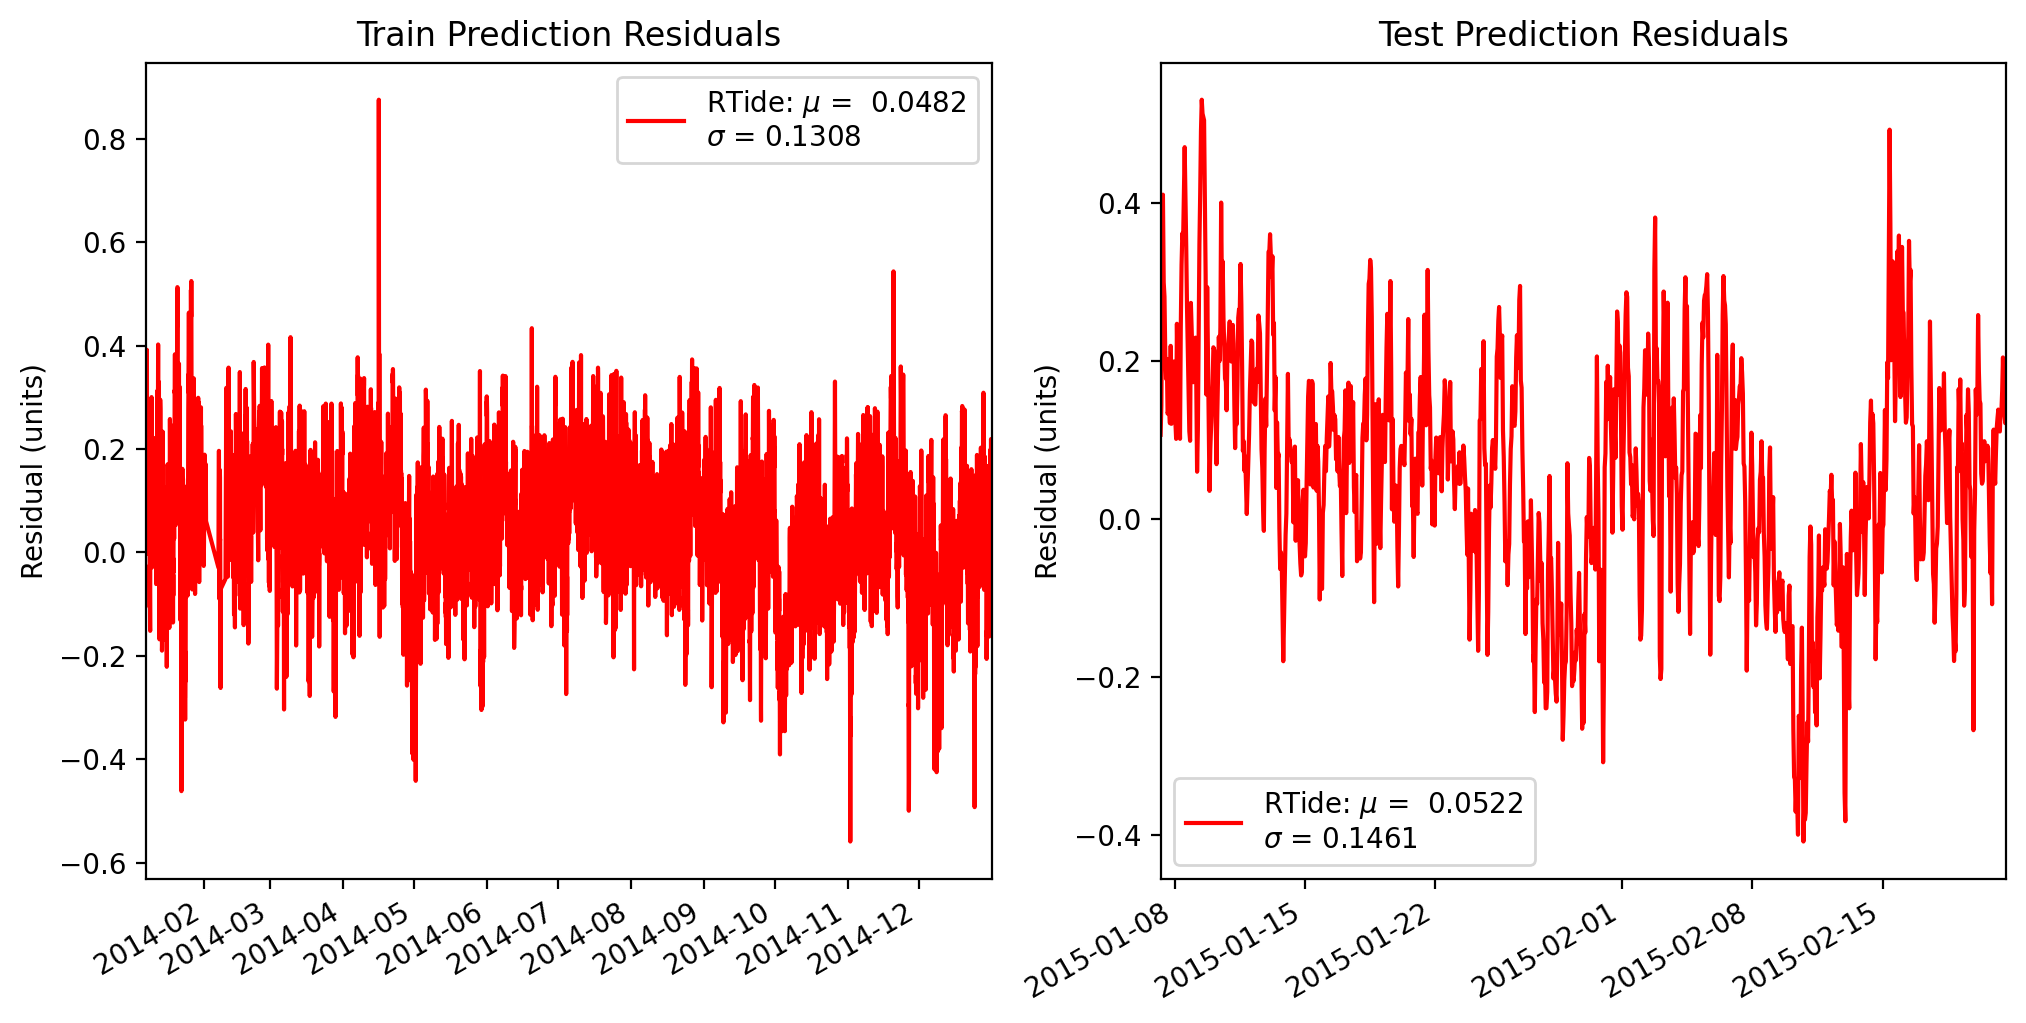

In [13]:
model.Visualize_Residuals(tides = False)

Train Results
r2: 0.81789616315815 MSE: 0.019436626876420608 MAE : 0.11093242001071384 MAPE : 3.117018307098768
Test Results
r2: 0.7922054420861832 MSE: 0.024074735538289628 MAE : 0.12462494370175417 MAPE : 2.037851335309463


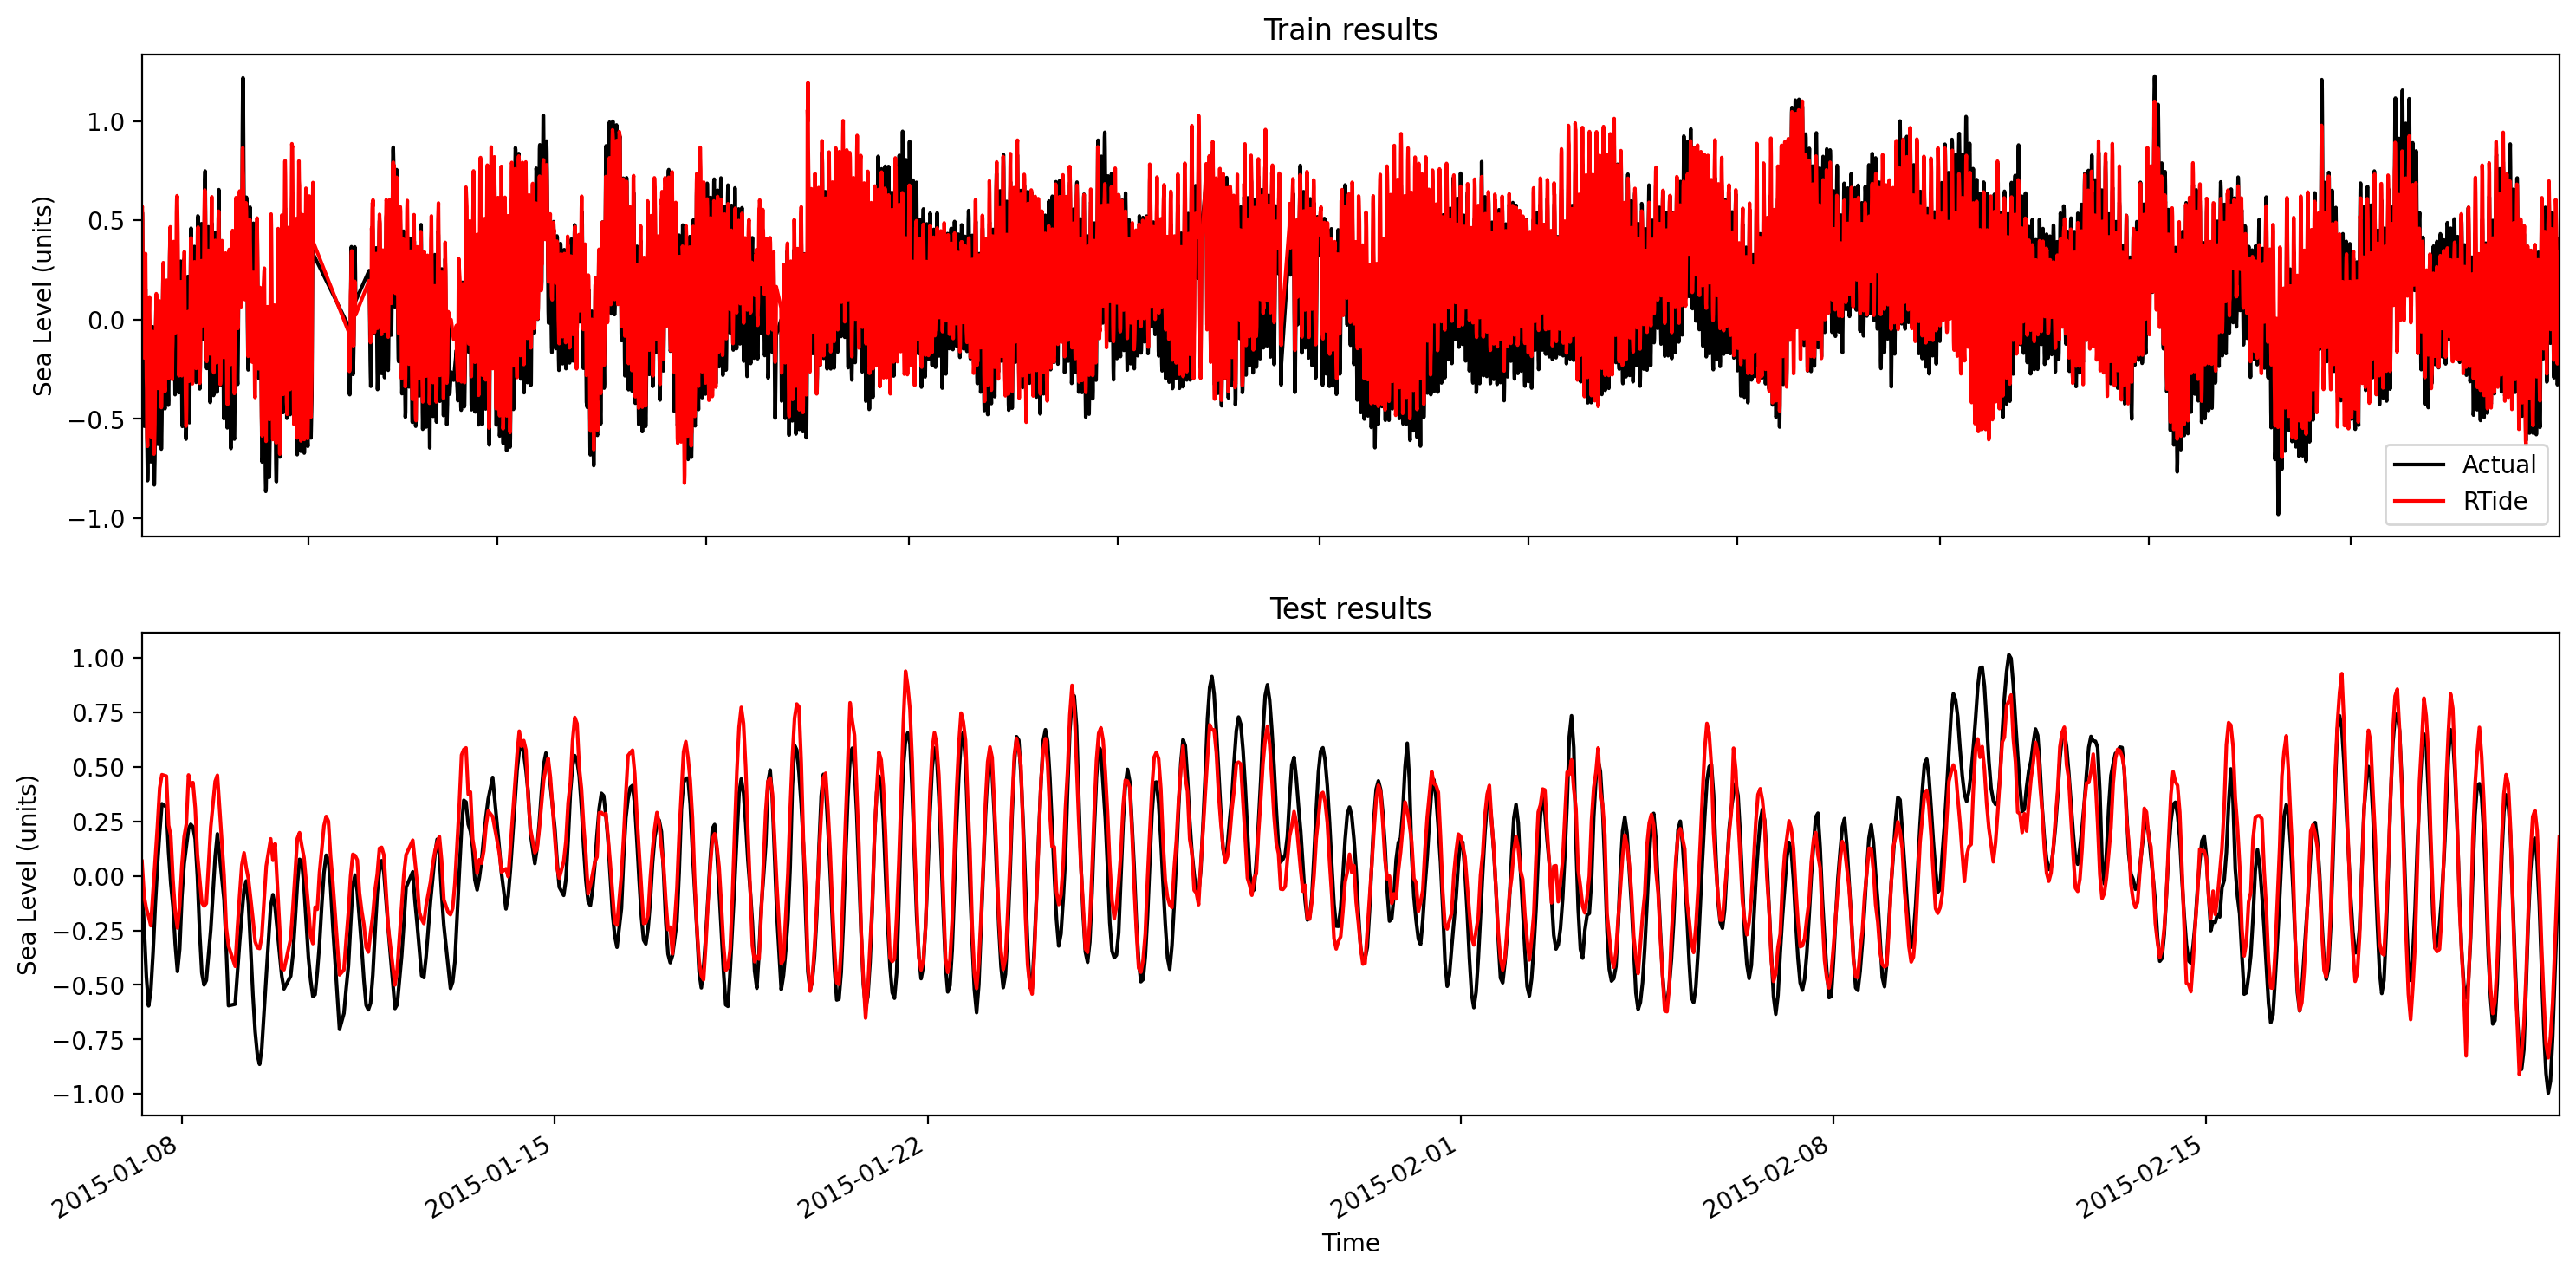

In [14]:
model.Visualize_Predictions()

1/1 [==============================] - 0s 32ms/step


  0%|          | 0/1051 [00:00<?, ?it/s]

141/141 [==============================] - 0s 2ms/step


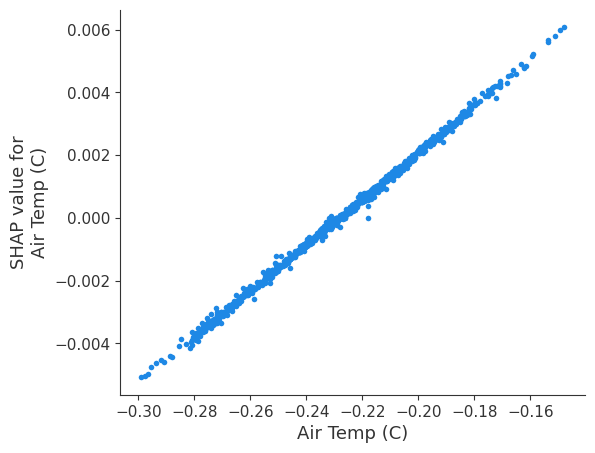

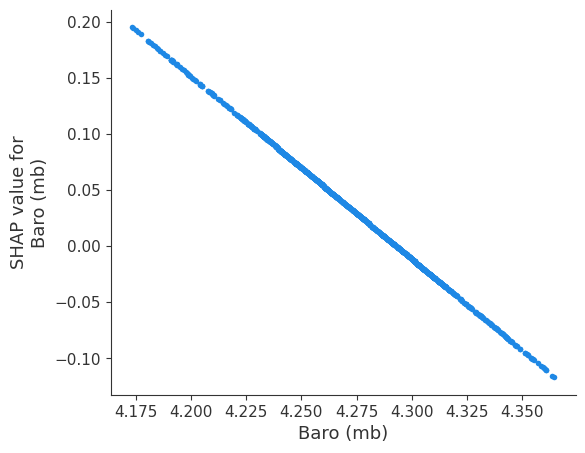

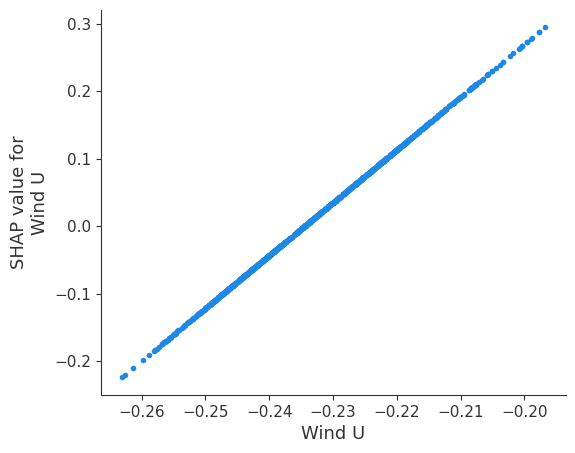

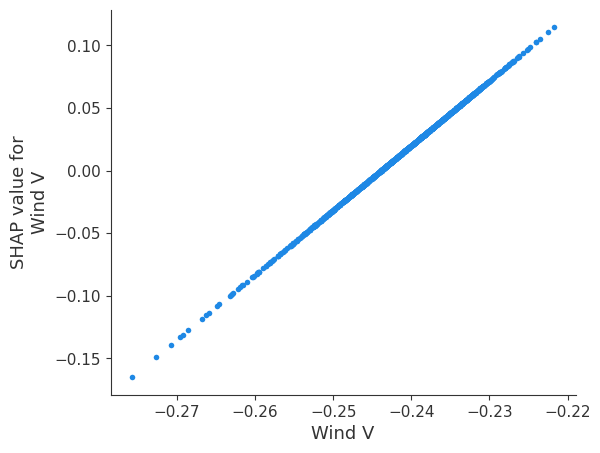

In [15]:
model.Shap_Analysis()